<a href="https://colab.research.google.com/github/Miguel-LlamasLanza/Fink_earlyTDE_v2/blob/main/notebooks/Preprocessing_cuts_and_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Load data**

In [4]:
#Run to download necessary files to the notebook

import pathlib
import os

data_dir = '/content'
pathlib.Path(data_dir).mkdir(parents=True, exist_ok=True)

files_to_download = {
    os.path.join(data_dir, "mallorn_data_fink_SNR_Full_LCs.pkl"): "1DNk-sk3a2fC1v8dCx6KqyHDjtxMLWi2W",
    os.path.join(data_dir, "mallorn_data_fink_SNR_30d_LCs.pkl"): "1bb1fgySX2KRMFxWLzSpFbLfq3vUOtWtj"}

for fpath, fid in files_to_download.items():
    url = f"https://drive.google.com/uc?id={fid}"
    if not os.path.exists(fpath):
        print(f"Downloading {os.path.basename(fpath)}...")
        !gdown "{url}" -O "{fpath}"
    else:
        print(f"{os.path.basename(fpath)} already exists, skipping.")

Downloading...
From: https://drive.google.com/uc?id=1DNk-sk3a2fC1v8dCx6KqyHDjtxMLWi2W
To: /content/mallorn_data_fink_SNR_Full_LCs.pkl
100% 31.7M/31.7M [00:00<00:00, 41.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bb1fgySX2KRMFxWLzSpFbLfq3vUOtWtj
To: /content/mallorn_data_fink_SNR_30d_LCs.pkl
100% 33.7M/33.7M [00:00<00:00, 39.8MB/s]


In [5]:
# Load data
import pandas as pd
df = pd.read_pickle('mallorn_data_fink_SNR_30d_LCs.pkl')

In [6]:
df.head()

,object_id,redshift,ebv,SpecType,target,lightcurve,n_detections,lightcurve_preprocessed_30d
0,Dornhoth_fervain_onodrim,3.0490,0.110,AGN,0,mjd time_t0 filter flux fl...,13,mjd time_t0 filter flux flu...
1,Dornhoth_galadh_ylf,0.4324,0.058,SN II,0,mjd time_t0 filter flux f...,11,mjd time_t0 filter flux f...
2,Elrim_melethril_thul,0.4673,0.577,AGN,0,mjd time_t0 filter flux fl...,20,mjd time_t0 filter flux flux...
3,Ithil_tobas_rodwen,0.6946,0.012,AGN,0,mjd time_t0 filter flux f...,82,mjd time_t0 filter flux fl...
4,Mirion_adar_Druadan,0.4161,0.058,AGN,0,mjd time_t0 filter flux f...,18,mjd time_t0 filter flux flu...


### **2. Define filtering Functions**


In [7]:
import numpy as np

def get_slope(x, y, dy):
    x = np.atleast_1d(x)
    y = np.atleast_1d(y)
    dy = np.atleast_1d(dy)

    idx = np.isfinite(x) & np.isfinite(y) & np.isfinite(dy)

    if len(x[idx]) < 3 or np.ptp(x[idx]) == 0:
        return 0, 0

    p, cov = np.polyfit(
        x[idx] - np.mean(x[idx]), y[idx] - np.mean(y), 1, w=1 / dy[idx], cov="unscaled"
    )
    dp = np.sqrt(np.diag(cov))

    return p[0], dp[0]


def is_rising(
    jd,
    flux,
    fluxerr,
    filter,
    upper=None,
    nsigmas_rise=2,
    nsigmas_decay=1,
    nsigmas_slope=3,
    use_slope=True,
    verbose=False,
):
    idx0 = flux == flux

    is_decay = False
    is_rise = False

    for filt in ['u', 'g', 'r', 'i', 'z', 'y']:

        idx = idx0 & (filter == filt)
        uidx = ~idx0 & (filter == filt)

        if np.sum(idx) < 2:
            continue

        # Last point is significantly lower than the max?..
        diff = flux[idx][:-1] - flux[idx][-1]
        differr = np.hypot(fluxerr[idx][:-1], fluxerr[idx][-1])

        if np.any(diff > nsigmas_decay * differr):
            is_decay = True

        # Last point is significantly higher than the min?..
        diff = flux[idx][-1] - flux[idx][:-1]

        if np.any(diff > nsigmas_rise * differr):
            is_rise = True

        if np.sum(idx) >= 3 and use_slope:
            # Slope is significantly positive?..
            slope, serr = get_slope(jd[idx], flux[idx], fluxerr[idx])
            if verbose:
                print("slope", slope, "+/-", serr)
            if slope > nsigmas_slope * serr:
                is_rise = True

        # Any point is significantly lower than the previous?..
        diff = flux[idx][:-1] - flux[idx][1:]
        differr = np.hypot(fluxerr[idx][:-1], fluxerr[idx][1:])

        if np.any(diff > nsigmas_decay * differr):
            is_decay = True

        # Last point is significantly higher than any (prior) upper limit?..
        if upper is not None and np.sum(uidx) > 0:
            diff = flux[idx][-1] - upper[uidx]
            differr = fluxerr[idx][-1]

            if np.any(diff > nsigmas_rise * differr):
                is_rise = True

    if verbose:
        print("rise", is_rise, "decay", is_decay)

    return is_rise and not is_decay


### **3. Define feature extraction functions**

In [50]:
try:
  from light_curve.light_curve_py import RainbowFit
except ModuleNotFoundError:

  !git clone https://github.com/light-curve/light-curve-python.git
  !pip install 'light-curve[full]'
  from light_curve.light_curve_py import RainbowFit




Cloning into 'light-curve-python'...
remote: Enumerating objects: 19703, done.
remote: Counting objects: 100% (726/726), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 19703 (delta 671), reused 594 (delta 586), pack-reused 18977 (from 3)
Receiving objects: 100% (19703/19703), 50.59 MiB | 17.57 MiB/s, done.
Resolving deltas: 100% (8933/8933), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.2/448.2 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 1.8 MB/s eta 0:00:00


In [123]:
band_wave_aa = {  # Wavelenght in angstrom for Rainbow in LSST
      "u": 3671.0,
      "g": 4827.0,
      "r": 6223.0,
      "i": 7546.0,
      "z": 8691.0,
      "y": 9712.0,
  }
feature = RainbowFit.from_angstrom(
    band_wave_aa,
    with_baseline=False,
    temperature="constant",
    bolometric="sigmoid",
)


def apply_rainbow_fit(lc, nsamples=None):

    try:

        params, errors, cov = feature._eval_and_get_errors(
            t=lc['mjd'],
            m=lc['flux'],
            sigma=lc['flux_err'],
            band=lc['filter'],
            # upper_mask=~idx_good,
            return_covariance=True,
            debug=True,
        )


        result = {}
        result["params"] = params
        result["errors"] = errors
        result["cov"] = cov

        if nsamples is not None:
            samples = []

            while True:
                params1 = np.random.multivariate_normal(params[:-1], cov)
                # Sanity checks
                if params1[feature.p["amplitude"]] < 0:
                    continue

                samples.append(params1)
                if len(samples) >= nsamples:
                    result["samples"] = samples
                    break

        return result
    except KeyboardInterrupt:
        raise
    except Exception:  # FIXME
        print('Error to Fix !')
        raise
        return None

def bad_quality_feat(res, nsamples = None):

  norm_rel_best = res["norm_rel_reference_time"] if nsamples is None else res["norm_rel_reference_time"][0]
  return (
      res["r_chisq"] > 10
      or res["e_reference_time"] > 100
      or norm_rel_best > 1
      or norm_rel_best < -10
      or res["snr_rise_time"] < 1.5
      or res["snr_temperature"] < 1.5
          )


def extract_features(lc, nsamples=None, post_fit_filtering = False):
  # Extract Rainbow features - best fit and sampled according to covariances
  res1 = apply_rainbow_fit(lc, nsamples=nsamples)
  jd_max=np.max(lc["mjd"])
  # Initial quality cuts for the fit
  if res1 is None:
      return

  # Actual features
  res = {}
  for i, name in enumerate(feature.names):
      if name == "T":
          # Normalize temperature name
          name = "temperature"
      if nsamples is None:
        res[name] = res1["params"][i]
      else:
        res[name] = np.array([res1["params"][i]] + [_[i] for _ in res1["samples"]])

      res["e_" + name] = res1["errors"][i]

      if name not in ["reference_time"]:
          res["snr_" + name] = np.abs(res1["params"][i] / res1["errors"][i])

  res["r_chisq"] = res1["params"][-1]
  res["rel_reference_time"] = res["reference_time"] - jd_max
  res["norm_rel_reference_time"] = res["rel_reference_time"] / res["rise_time"]
  # res["distnr"] = np.nanmin(pdf["i:distnr"])

  # Features quality cuts
  if post_fit_filtering and bad_quality_feat(res, nsamples):
      return
  return res

def extract_features_no_cuts(lc):
  return extract_features(lc, post_fit_filtering=False)



/usr/local/lib/python3.12/dist-packages/light_curve/light_curve_py/warnings.py:19: ExperimentalWarning: Function light_curve.light_curve_py.features.rainbow.generic.RainbowFit is experimental and may cause any kind of troubles
  warn_experimental(message)


### **4. Apply cuts and feature extract for each alert**
Loops through each alert of each object, defines the lightcurve to be processed (detections + 30d forced photometry), applies cuts and extract features (Rainbow)

In [124]:
features_list = []

for _, row in df.iterrows():

  # Loop through each alertand define light curve (SNR > 5 + 30d fp)
  for jd_max in sorted(row['lightcurve']['mjd']):

    mask_lc = (row['lightcurve']['mjd'] <= jd_max) & (row["lightcurve"]["detection_5SNR"])
    if row['lightcurve_preprocessed_30d'] is not None:
      mask_lc_plus30d = (mask_lc | row['lightcurve'].index.isin(row['lightcurve_preprocessed_30d'].index)) & np.isfinite(row['lightcurve']['flux_dered'])
    else:
      mask_lc_plus30d = mask_lc & np.isfinite(row['lightcurve']['flux_dered'])

    # Get lc arrays
    lc = {
        'mjd': row['lightcurve']['mjd'][mask_lc_plus30d].to_numpy(),
        'flux': row['lightcurve']['flux_dered'][mask_lc_plus30d].to_numpy(),
        'flux_err': row['lightcurve']['flux_err_dered'][mask_lc_plus30d].to_numpy(),
        'filter': row['lightcurve']['filter'][mask_lc_plus30d]
        }

    # Apply rising criteria
    rising_flag = is_rising(lc['mjd'], lc['flux'], lc['flux_err'], lc['filter'],
                     verbose = False)

    # Require at least 5 points for the fit
    flag_5points = len(lc['mjd']) > 5

    # Apply Rainbow fit
    features = None
    if rising_flag and flag_5points:
      features = extract_features(lc)

    # Add metadata
    results = {
			"object_id": row["object_id"],
			"SpecType": row["SpecType"],
			"jd_max": jd_max,
			"rising_flag": rising_flag,
			"flag_5points": flag_5points,
		}

    # Add features
    if isinstance(features, dict):
      results.update(features)
    features_list.append(results)
# Create dataframe
feat_df = pd.DataFrame(features_list)

# Add flag corresponding to postfit quality cuts
feat_df["passes_feature_quality_cuts"] = (~feat_df.apply(
        lambda x: bad_quality_feat(x),axis=1))




In [125]:
feat_df

,object_id,SpecType,jd_max,rising_flag,flag_5points,reference_time,e_reference_time,amplitude,e_amplitude,snr_amplitude,rise_time,e_rise_time,snr_rise_time,temperature,e_temperature,snr_temperature,r_chisq,rel_reference_time,norm_rel_reference_time
0,Dornhoth_fervain_onodrim,AGN,63314.4662,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Dornhoth_fervain_onodrim,AGN,63314.4662,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Dornhoth_fervain_onodrim,AGN,63327.6691,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Dornhoth_fervain_onodrim,AGN,63327.6691,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Dornhoth_fervain_onodrim,AGN,63340.8720,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479379,ylf_alph_mindon,SN Ia-91T-like,64587.7068,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
479380,ylf_alph_mindon,SN Ia-91T-like,64587.7068,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
479381,ylf_alph_mindon,SN Ia-91T-like,64594.8036,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
479382,ylf_alph_mindon,SN Ia-91T-like,64623.1911,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:

feat_df.columns

Index(['object_id', 'SpecType', 'jd_max', 'rising_flag', 'flag_5points',
       'reference_time', 'e_reference_time', 'amplitude', 'e_amplitude',
       'snr_amplitude', 'rise_time', 'e_rise_time', 'snr_rise_time',
       'temperature', 'e_temperature', 'snr_temperature', 'r_chisq',
       'rel_reference_time', 'norm_rel_reference_time',
       'passes_feature_quality_cuts'],
      dtype='object')

# Analyses and plots


In [139]:
def count_types(df):

	def counts(subdf):
		return (
			len(subdf),
			subdf["object_id"].nunique()
		)

	total_alerts, total_objs = counts(df)

	agn_alerts, agn_objs = counts(df[df.SpecType == "AGN"])
	tde_alerts, tde_objs = counts(df[df.SpecType == "TDE"])
	other_alerts, other_objs = counts(
		df[~df["SpecType"].isin(["AGN", "TDE"])]
	)

	return [
		f"{total_alerts} ({total_objs})",
		f"{agn_alerts} ({agn_objs})",
		f"{tde_alerts} ({tde_objs})",
		f"{other_alerts} ({other_objs})",
	]


In [141]:
summary = pd.DataFrame(
	[ ["", "Alerts (obj)", "Alerts (obj)", "Alerts (obj)", "Alerts (obj)"],
		["Original dataset"] + count_types(feat_df),

		["After rising cut"] + count_types(
			feat_df[feat_df["rising_flag"]]
		),

		["Minimum 5 points"] + count_types(
			feat_df[
				feat_df["rising_flag"] &
				feat_df["flag_5points"]
			]
		),

		["After Rainbow fit"] + count_types(
			feat_df[
				feat_df["rising_flag"] &
				feat_df["flag_5points"]
			]
		),

		["After post-fit cuts"] + count_types(
			feat_df[
				feat_df["rising_flag"] &
				feat_df["flag_5points"] &
				feat_df["passes_feature_quality_cuts"]
			]
		),
	],
	columns=["Stage", "Total", "AGN", "TDEs", "Others"]
)
print(summary.to_string(index=False))

              Stage         Total           AGN         TDEs        Others
                     Alerts (obj)  Alerts (obj) Alerts (obj)  Alerts (obj)
   Original dataset 479384 (3043) 262896 (1786)  23840 (148) 192648 (1109)
   After rising cut  77910 (1846)  26104 (1000)    4179 (87)   47627 (759)
   Minimum 5 points  58888 (1691)   19698 (909)    2082 (78)   37108 (704)
  After Rainbow fit  58888 (1691)   19698 (909)    2082 (78)   37108 (704)
After post-fit cuts   18394 (870)    4183 (277)     834 (60)   13377 (533)


In [146]:
feat_df.to_csv("feature_data.csv")

## Plots

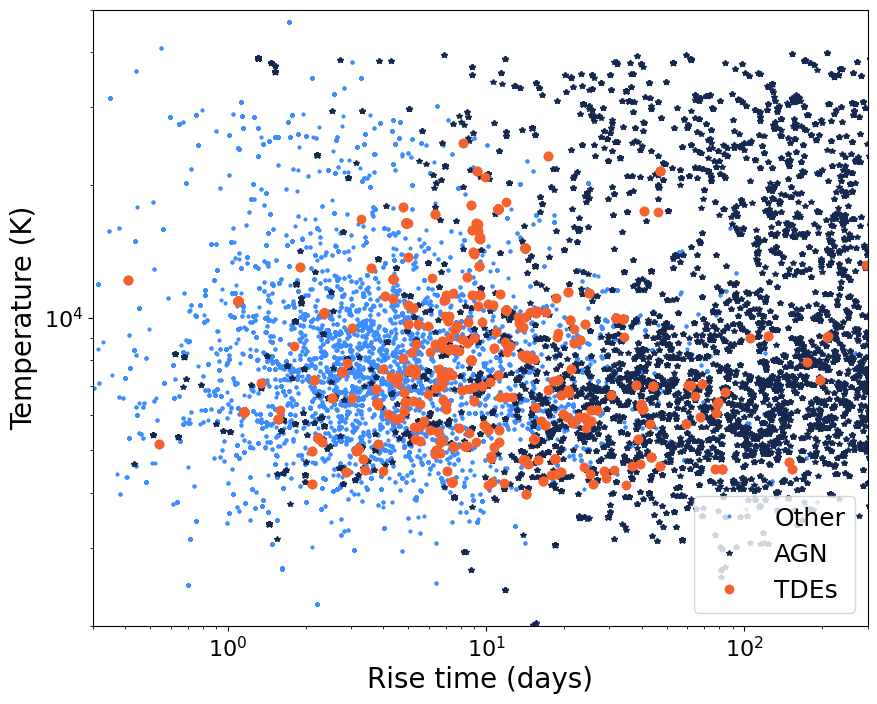

In [145]:
# Plotting
import matplotlib.pyplot as plt
ax = plt.figure(figsize=(10,8)).gca()
COLORS_ZTF = {1: "#15284F", 2: "#F5622E", 3: "#3C8DFF", 4: "#D5D5D3"}

agn_index = feat_df.SpecType == "AGN"
tde_idx = feat_df.SpecType == "TDE"

plt.plot(feat_df['rise_time'][~tde_idx & ~agn_index], feat_df['temperature'][~tde_idx & ~agn_index], '.', ms=4, color=COLORS_ZTF[3], label='Other', rasterized=True)
plt.plot(feat_df['rise_time'][agn_index], feat_df['temperature'][agn_index], '*', color=COLORS_ZTF[1], ms = 4, label='AGN', rasterized=True)
plt.plot(feat_df['rise_time'][tde_idx], feat_df['temperature'][tde_idx], 'o', color=COLORS_ZTF[2], ms=6, label='TDEs')


# plt.legend(fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rise time (days)', fontsize = 20)
plt.ylabel('Temperature (K)', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=16) #, width=2.5, length=10)
# plt.grid(alpha=0.2)
plt.xlim(3e-1, 3e2)
plt.ylim(2e3, 5e4)

ax.legend(fontsize = 18)